# Getting the Data

Using Socrata, we imported two datasets using the New York City Open Data Portal APIs. It included a dataset of property valuations in New York City, and another dataset listing the reassesment actions. App_tokens were used to adjust limits for valuation results and testing our code on smaller/larger datasets. 

In [2]:
import pandas as pd
import geopandas as gpd
from sodapy import Socrata
import matplotlib.pyplot as plt
import contextily as ctx

In [3]:
client = Socrata("data.cityofnewyork.us", '9llM0ejMVTKfRxS1XlvL7gXjU')

In [4]:
#first one is the property valuation and assessment dataset, need to update the limit for this as we go forward (there are 9 million+ entries)
vresults = client.get("yjxr-fw8i", content_type='geojson', year = '2017/18', limit=10000000)
value_gdf = gpd.GeoDataFrame.from_features(vresults, crs='EPSG:4326')

#second one is the assessment actions dataset
aresults = client.get("4nft-bihw", content_type='json', limit=100000) 
actions_df = pd.DataFrame.from_records(aresults)

In [5]:
value_gdf.head()

geometry   nta avland latitude    zip stories   avtot easement valtype  \
0     None  None   4253     None   None      31  199067     None   AC-TR   
1     None  None   5803     None   None      31  271593     None   AC-TR   
2     None  None   3553     None   None      31  166279     None   AC-TR   
3     None  None      0     None  10004    None       0        E   AC-TR   
4     None  None   4912     None   None      31  229897     None   AC-TR   

  exland  ... excd2                owner   extot  extot2 exland2  \
0   4253  ...  None  FORTUNATO, KATHLEEN  199067  185013    4253   
1   5803  ...  None          BEREN, ERIC  271593  252417    5803   
2   3553  ...  None   STEINBERG, DOUGLAS  166279  154541    3553   
3      0  ...  None          NYC TRANSIT       0    None    None   
4   4912  ...  None        HSIEH, TOBY T  229897  213665    4912   

  community_board borough period council_district ltdepth  
0            None    None  FINAL             None       0  
1            None    None  FINAL             None       0  
2            None    None  FINAL             None       0  
3            None    None  FINAL             None       0  
4            None    None  FINAL             None       0  

[5 rows x 40 columns]

In [6]:
#some of the data does not have geometry

In [7]:
actions_df.head()

borough_code block_number lot_number tax_year             owner_name  \
0            1            7         29     2017  SONS OF THE REVOLUTIO   
1            1            7         29     2018  SONS OF THE REVOLUTIO   
2            1            7         30     2017  SONS OF THE REVOLUTIO   
3            1            7         30     2018  SONS OF THE REVOLUTIO   
4            1            7         31     2017  FASHION MANAGMENT COR   

   property_address granted_reduction_amount tax_class_code  
0   26 WATER STREET                    34950              4  
1   26 WATER STREET                    23300              4  
2   24 WATER STREET                    55550              4  
3   24 WATER STREET                    36850              4  
4  105 BROAD STREET                    59450              4

plotting the property values one to see if the geodataframe worked

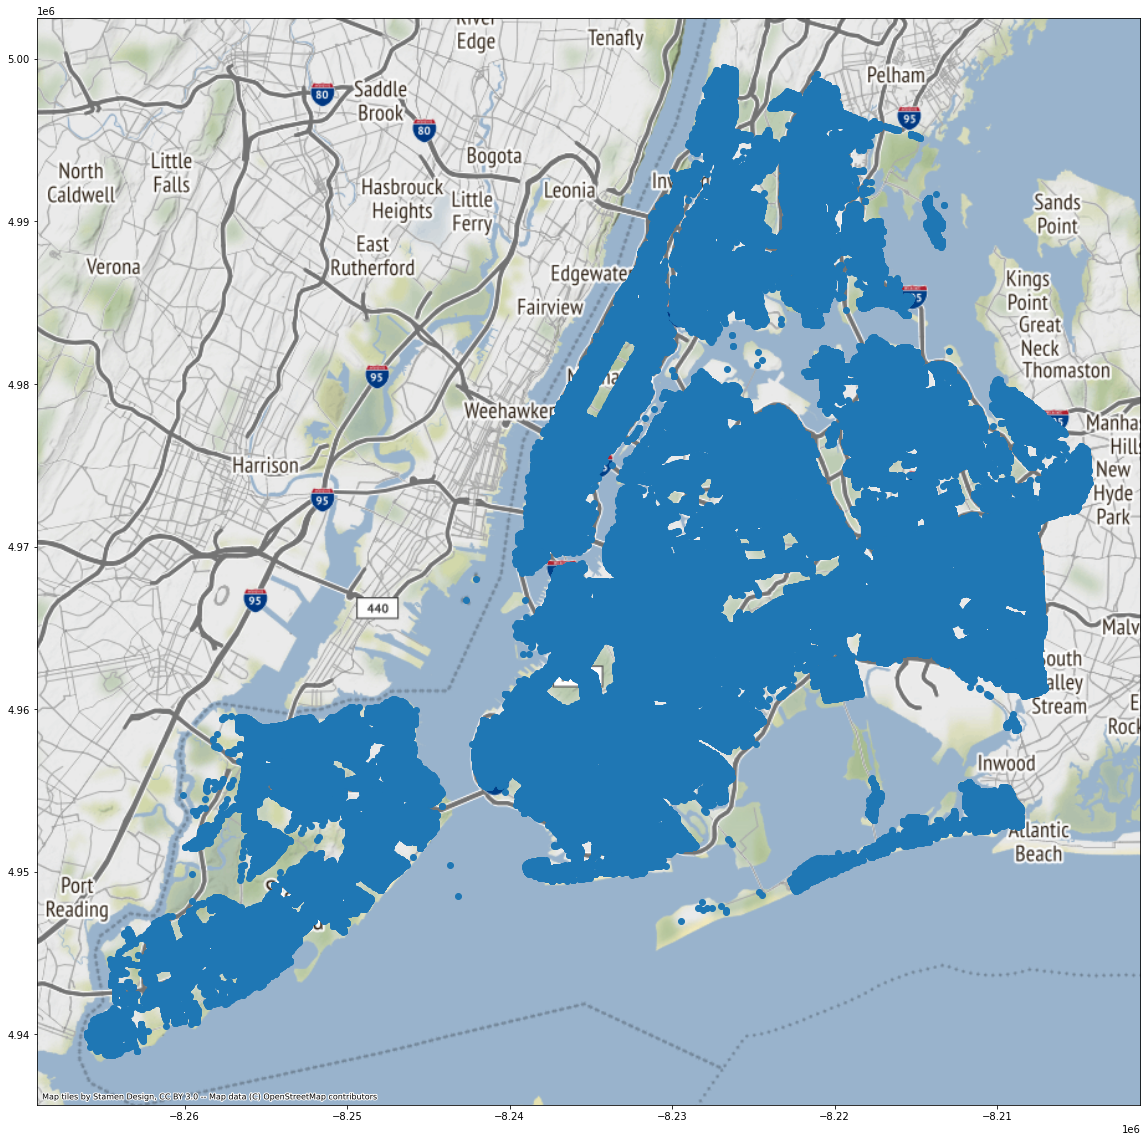

In [8]:
fig, ax = plt.subplots(figsize=(20,20))
value_gdf.to_crs('EPSG:3857').plot(ax=ax)
ctx.add_basemap(ax)

in order to combine the two datasets i made a new column in each that combines the borough, block, and lot numbers (keeping it as a string)

In [9]:
value_gdf['BBB'] = value_gdf['boro'] + '-' + value_gdf['block'] + '-' + value_gdf['lot']
value_gdf['BBB']

0           1-16-3633
1           1-16-3634
2           1-16-3635
3             1-13-27
4           1-16-3666
              ...    
1110053     5-7074-43
1110054     5-7893-10
1110055     5-7890-79
1110056     5-7317-50
1110057    5-7826-224
Name: BBB, Length: 1110058, dtype: object

In [10]:
actions_df['BBB'] = actions_df['borough_code'] + '-' + actions_df['block_number'] + '-' + actions_df['lot_number']
actions_df['BBB']

0            1-7-29
1            1-7-29
2            1-7-30
3            1-7-30
4            1-7-31
            ...    
12316    5-72614-11
12317     5-72616-1
12318     5-72616-1
12319     5-72830-5
12320     5-72830-5
Name: BBB, Length: 12321, dtype: object

next i set the indexes in each to the new BBB identifiers

In [11]:
actions_df.set_index('BBB', inplace=True)
value_gdf.set_index('BBB', inplace=True)

then i joined them using an inner join to just get the results where both datasets had the same BBB

we should probably double check this going forward and see if we missed any properties

In [12]:
joined_gdf = value_gdf.join(actions_df, how='inner', rsuffix=('_actions'))

In [13]:
print('number of properties that overlap between the two datasets is '+str(len(joined_gdf)))
print('actions dataset length is '+str(len(actions_df)))
print('valuation dataset length is '+str(len(value_gdf)))

number of properties that overlap between the two datasets is 12346
actions dataset length is 12321
valuation dataset length is 1110058


In [31]:
#we have more rows in the joined dataset than the assessments dataset, which will need investigated

In [32]:
#checking the columns

In [14]:
joined_gdf.columns

Index(['geometry', 'nta', 'avland', 'latitude', 'zip', 'stories', 'avtot',
       'easement', 'valtype', 'exland', 'blddepth', 'year', 'taxclass',
       'longitude', 'bldfront', 'bldgcl', 'block', 'avtot2', 'excd1', 'bble',
       'staddr', 'exmptcl', 'avland2', 'census_tract', 'lot', 'boro',
       'ltfront', 'fullval', 'ext', 'bin', 'excd2', 'owner', 'extot', 'extot2',
       'exland2', 'community_board', 'borough', 'period', 'council_district',
       'ltdepth', 'borough_code', 'block_number', 'lot_number', 'tax_year',
       'owner_name', 'property_address', 'granted_reduction_amount',
       'tax_class_code'],
      dtype='object')

making a new column of the reduction amount divided by the actual total value of the property

In [15]:
#making them numeric first
joined_gdf['granted_reduction_amount']=pd.to_numeric(joined_gdf['granted_reduction_amount'])
joined_gdf['avtot']=pd.to_numeric(joined_gdf['avtot'])

#making the new column
joined_gdf['reduction_scaled']=joined_gdf['granted_reduction_amount']/joined_gdf['avtot']

plotting the properties that have been granted reductions with marker size based on the scaled reduction amount

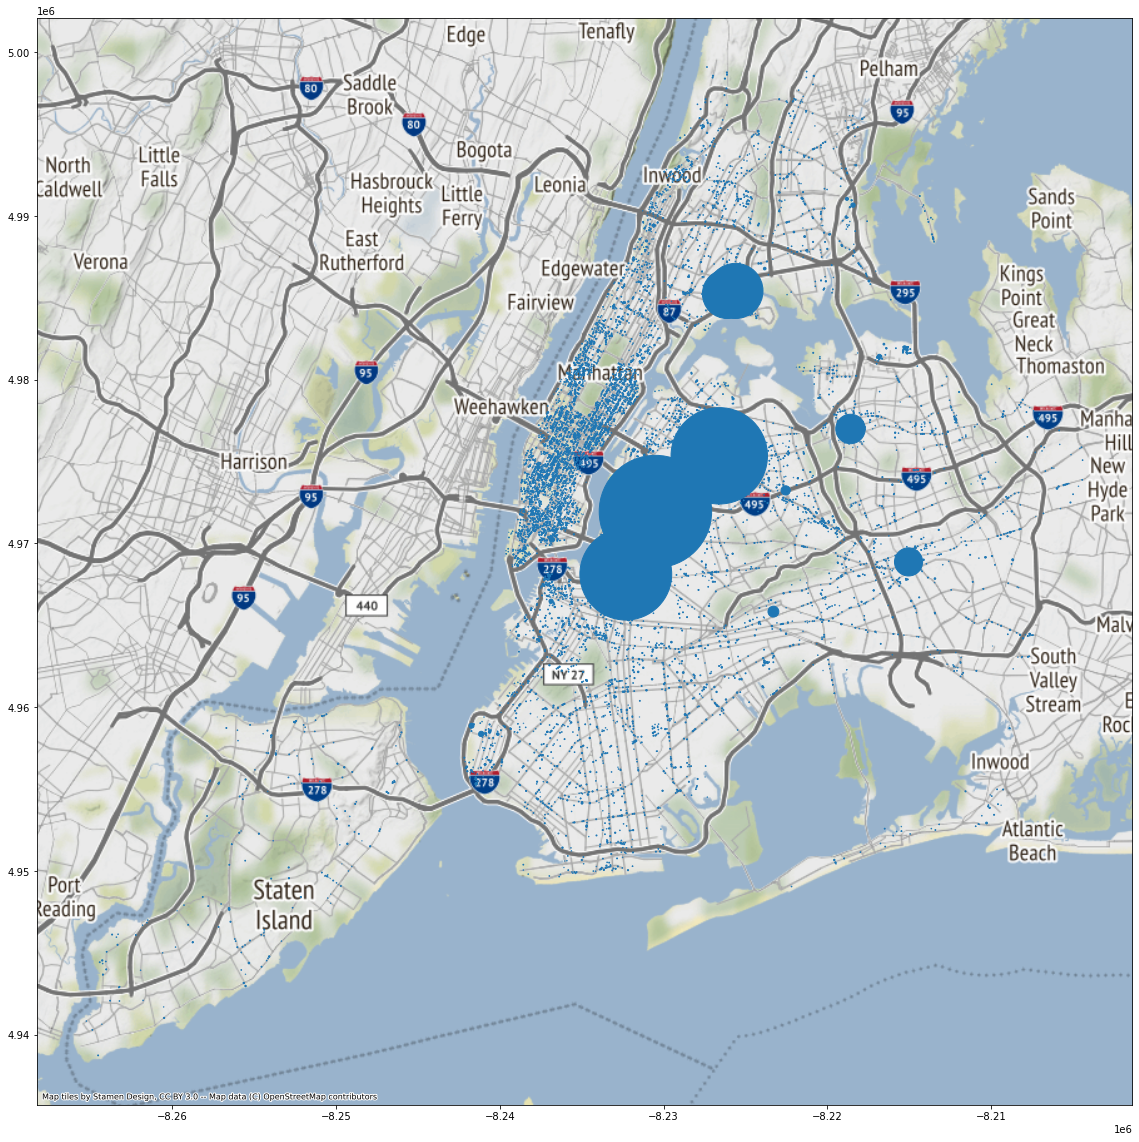

In [16]:
fig, ax = plt.subplots(figsize=(20,20))
joined_gdf.to_crs('EPSG:3857').plot(ax=ax, markersize=joined_gdf['reduction_scaled']*5)
ctx.add_basemap(ax)

**going forward we need:**
- to increase the size of the valuation dataset that we use (by getting an app_token)
- to figure out how to better visualize the reductions in value (some of the values are super different than others and there are going to be a bunch of points). maybe we plot them by borough?
- maybe spatial join to tracts so that we can summarize the data by census tracts

## Census Data ##

In [41]:
#using cenpy to get ACS census tract data

In [17]:
from cenpy import products

#starting with median household income data
incomeDf = products.ACS(2017).from_place('New York City', level='tract',
                                        variables=['B19019_001E', 'B01003_001E', '^B02001', 'B03003_003E', 'B25003_001E', 'B25003_002E', 'B25003_003E', 'B09001_001E', 'B01002_001E'])
#B01003_001E is total pop, B02001_001E is total race, B02001_002E is white, B02001_003E is black, B02001_004E is american indian or alaska, B02001_005E is asian, 
#B02001_006E is hawaiian, B02001_007E is some other race, B02001_008E is two or more races, B03003_003E is hispanic or latino origin
#19019 is median income, 25003 is tenure, B09001_001E is population under 18 years old, B01002_001E is median age
incomeDf.rename(columns={'B19019_001E':'median_HH_income', 'B01003_001E':'total_population', 'B02001_001E':'total_population_race','B02001_002E':'total_white'}, inplace=True)
incomeDf.rename(columns={'B02001_003E':'total_black', 'B02001_004E':'total_americanindian', 'B02001_005E':'total_asian','B02001_006E':'total_hawaiian'}, inplace=True)
incomeDf.rename(columns={'B02001_007E':'total_otherrace', 'B02001_008E':'total_twoplusraces', 'B03003_003E':'total_hisp_latino','B09001_001E':'pop_under18','B01002_001E':'median_age'}, inplace=True)
incomeDf.head()

/Users/shintuzd/opt/anaconda3/envs/uds/lib/python3.8/site-packages/cenpy/products.py:791: UserWarning: Uncertain place identifier "New York City". The place identifier should look something like "placename, state" or, for larger areas, like Combined Statistical Areas or Metropolitan Statistical Areas,"placename1-placename2, state1-state2-state3"
  geoms, variables, *rest = super(ACS, self).from_place(
/Users/shintuzd/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/shintuzd/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis or

Matched: New York City to New York city within layer Incorporated Places


/Users/shintuzd/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/shintuzd/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/c7/zpty205x53s48zvfyzq_xx740000gn/T/ipykernel_2449/3808511758.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  incomeDf = products.ACS(2017).fro

GEOID                                           geometry  median_age  \
0  36085017012  POLYGON ((-8257822.870 4945745.990, -8257700.4...        43.6   
1  36085014607  POLYGON ((-8256547.370 4947814.750, -8256220.4...        44.3   
2  36085027706  POLYGON ((-8256097.640 4952157.350, -8255857.1...        36.7   
3  36085014605  POLYGON ((-8254991.570 4948209.800, -8254909.4...        47.8   
4  36085024700  POLYGON ((-8254048.590 4957893.610, -8253996.2...        32.4   

   total_population  total_population_race  total_white  total_black  \
0            4526.0                 4526.0       4193.0         23.0   
1            4539.0                 4539.0       3860.0         65.0   
2            3658.0                 3658.0       2463.0        316.0   
3            3680.0                 3680.0       3572.0          9.0   
4            2755.0                 2755.0       1395.0        701.0   

   total_americanindian  total_asian  total_hawaiian  ...  B02001_010E  \
0                  11.0        152.0            15.0  ...         70.0   
1                   0.0        530.0             0.0  ...         64.0   
2                   0.0        746.0             0.0  ...         29.0   
3                   0.0         70.0             0.0  ...          0.0   
4                   0.0        255.0             2.0  ...        112.0   

   total_hisp_latino  pop_under18  median_HH_income  B25003_001E  B25003_002E  \
0              681.0        919.0           91131.0       1675.0       1352.0   
1              280.0        952.0           74630.0       1700.0       1222.0   
2              542.0        831.0           80286.0       1160.0        823.0   
3              429.0        676.0          107589.0       1332.0       1143.0   
4             1094.0        582.0           56875.0       1012.0        530.0   

   B25003_003E  state  county   tract  
0        323.0     36     085  017012  
1        478.0     36     085  014607  
2        337.0     36     085  027706  
3        189.0     36     085  014605  
4        482.0     36     085  024700  

[5 rows x 23 columns]

In [18]:
censusDf = incomeDf

In [19]:
censusDf.drop(columns=['total_population_race', 'B02001_009E', 'B02001_010E'], inplace=True)
censusDf['pct_renter'] = censusDf['B25003_003E']/censusDf['B25003_001E']*100

censusDf.columns

Index(['GEOID', 'geometry', 'median_age', 'total_population', 'total_white',
       'total_black', 'total_americanindian', 'total_asian', 'total_hawaiian',
       'total_otherrace', 'total_twoplusraces', 'total_hisp_latino',
       'pop_under18', 'median_HH_income', 'B25003_001E', 'B25003_002E',
       'B25003_003E', 'state', 'county', 'tract', 'pct_renter'],
      dtype='object')

In [20]:
#using a spatial join to bring the point data for property values and reductions from above into the census tract dataset
sjoindf = censusDf.sjoin(joined_gdf.to_crs("EPSG:3857"),how='left')
sjoindf.head()

GEOID                                           geometry  median_age  \
0  36085017012  POLYGON ((-8257822.870 4945745.990, -8257700.4...        43.6   
0  36085017012  POLYGON ((-8257822.870 4945745.990, -8257700.4...        43.6   
0  36085017012  POLYGON ((-8257822.870 4945745.990, -8257700.4...        43.6   
1  36085014607  POLYGON ((-8256547.370 4947814.750, -8256220.4...        44.3   
1  36085014607  POLYGON ((-8256547.370 4947814.750, -8256220.4...        44.3   

   total_population  total_white  total_black  total_americanindian  \
0            4526.0       4193.0         23.0                  11.0   
0            4526.0       4193.0         23.0                  11.0   
0            4526.0       4193.0         23.0                  11.0   
1            4539.0       3860.0         65.0                   0.0   
1            4539.0       3860.0         65.0                   0.0   

   total_asian  total_hawaiian  total_otherrace  ...  ltdepth  borough_code  \
0        152.0            15.0             62.0  ...      105             5   
0        152.0            15.0             62.0  ...      100             5   
0        152.0            15.0             62.0  ...      705             5   
1        530.0             0.0              0.0  ...      240             5   
1        530.0             0.0              0.0  ...      125             5   

   block_number  lot_number  tax_year             owner_name  \
0          5639           8      2018        BOKTOR, RAFIK E   
0          5609           6      2018  BELAIR RIDGE DEVELOPM   
0          5533          58      2018  KIMCO GREENRIDGE 674,   
1          5533          62      2018  KIMCO GREENRIDGE 674,   
1          5533          47      2018  KIMCO GREENRIDGE 674,   

        property_address granted_reduction_amount tax_class_code  \
0      413 ANNADALE ROAD                   2346.0              1   
0    651 LEVERETT AVENUE                  40760.0             2B   
0   3231 RICHMOND AVENUE                2749260.0              4   
1   3247 RICHMOND AVENUE                 255100.0              4   
1  3245Q RICHMOND AVENUE                 383550.0              4   

  reduction_scaled  
0         0.085086  
0         0.137239  
0         0.283173  
1         0.197936  
1         0.277452  

[5 rows x 70 columns]

In [21]:
#now each point has an associated census tract
sjoindf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 11735 entries, 0 to 2060
Data columns (total 70 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   GEOID                     11735 non-null  object  
 1   geometry                  11735 non-null  geometry
 2   median_age                11644 non-null  float64 
 3   total_population          11735 non-null  float64 
 4   total_white               11735 non-null  float64 
 5   total_black               11735 non-null  float64 
 6   total_americanindian      11735 non-null  float64 
 7   total_asian               11735 non-null  float64 
 8   total_hawaiian            11735 non-null  float64 
 9   total_otherrace           11735 non-null  float64 
 10  total_twoplusraces        11735 non-null  float64 
 11  total_hisp_latino         11735 non-null  float64 
 12  pop_under18               11735 non-null  float64 
 13  median_HH_income          11586 non-nul

In [22]:
#making a new df with the total reduction amount granted per tract
tract_info = sjoindf.groupby('tract')[['granted_reduction_amount']].sum()
tract_info.head()

granted_reduction_amount
tract                           
000100                 4021688.0
000200                  564360.0
000201                   99350.0
000202                       0.0
000301                 6108482.0

In [23]:
#renaming the column to reflect that it's for the tract as a whole
tract_info.rename(columns={'granted_reduction_amount':'total_tract_reduction'}, inplace=True)

In [24]:
tract_info.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1299 entries, 000100 to 990100
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_tract_reduction  1299 non-null   float64
dtypes: float64(1)
memory usage: 20.3+ KB


In [25]:
#joining the total reduction data back to the census df to be able to plot it by tract
tractjoin = censusDf.join(tract_info, on='tract')

In [26]:
tractjoin.head()

GEOID                                           geometry  median_age  \
0  36085017012  POLYGON ((-8257822.870 4945745.990, -8257700.4...        43.6   
1  36085014607  POLYGON ((-8256547.370 4947814.750, -8256220.4...        44.3   
2  36085027706  POLYGON ((-8256097.640 4952157.350, -8255857.1...        36.7   
3  36085014605  POLYGON ((-8254991.570 4948209.800, -8254909.4...        47.8   
4  36085024700  POLYGON ((-8254048.590 4957893.610, -8253996.2...        32.4   

   total_population  total_white  total_black  total_americanindian  \
0            4526.0       4193.0         23.0                  11.0   
1            4539.0       3860.0         65.0                   0.0   
2            3658.0       2463.0        316.0                   0.0   
3            3680.0       3572.0          9.0                   0.0   
4            2755.0       1395.0        701.0                   0.0   

   total_asian  total_hawaiian  total_otherrace  ...  pop_under18  \
0        152.0            15.0             62.0  ...        919.0   
1        530.0             0.0              0.0  ...        952.0   
2        746.0             0.0             85.0  ...        831.0   
3         70.0             0.0             29.0  ...        676.0   
4        255.0             2.0            258.0  ...        582.0   

   median_HH_income  B25003_001E  B25003_002E  B25003_003E  state  county  \
0           91131.0       1675.0       1352.0        323.0     36     085   
1           74630.0       1700.0       1222.0        478.0     36     085   
2           80286.0       1160.0        823.0        337.0     36     085   
3          107589.0       1332.0       1143.0        189.0     36     085   
4           56875.0       1012.0        530.0        482.0     36     085   

    tract pct_renter total_tract_reduction  
0  017012  19.283582             2792366.0  
1  014607  28.117647              638650.0  
2  027706  29.051724              380600.0  
3  014605  14.189189                   0.0  
4  024700  47.628458             1522850.0  

[5 rows x 22 columns]

In [27]:
#adding another column for the total number of property reductions in a census tract
numberreductions = sjoindf.groupby('tract')[['tract']].count()
numberreductions.rename(columns={'tract':'number_reductions'}, inplace=True)
tractjoin = tractjoin.join(numberreductions, on='tract')
tractjoin.head()

GEOID                                           geometry  median_age  \
0  36085017012  POLYGON ((-8257822.870 4945745.990, -8257700.4...        43.6   
1  36085014607  POLYGON ((-8256547.370 4947814.750, -8256220.4...        44.3   
2  36085027706  POLYGON ((-8256097.640 4952157.350, -8255857.1...        36.7   
3  36085014605  POLYGON ((-8254991.570 4948209.800, -8254909.4...        47.8   
4  36085024700  POLYGON ((-8254048.590 4957893.610, -8253996.2...        32.4   

   total_population  total_white  total_black  total_americanindian  \
0            4526.0       4193.0         23.0                  11.0   
1            4539.0       3860.0         65.0                   0.0   
2            3658.0       2463.0        316.0                   0.0   
3            3680.0       3572.0          9.0                   0.0   
4            2755.0       1395.0        701.0                   0.0   

   total_asian  total_hawaiian  total_otherrace  ...  median_HH_income  \
0        152.0            15.0             62.0  ...           91131.0   
1        530.0             0.0              0.0  ...           74630.0   
2        746.0             0.0             85.0  ...           80286.0   
3         70.0             0.0             29.0  ...          107589.0   
4        255.0             2.0            258.0  ...           56875.0   

   B25003_001E  B25003_002E  B25003_003E  state  county   tract pct_renter  \
0       1675.0       1352.0        323.0     36     085  017012  19.283582   
1       1700.0       1222.0        478.0     36     085  014607  28.117647   
2       1160.0        823.0        337.0     36     085  027706  29.051724   
3       1332.0       1143.0        189.0     36     085  014605  14.189189   
4       1012.0        530.0        482.0     36     085  024700  47.628458   

  total_tract_reduction number_reductions  
0             2792366.0                 3  
1              638650.0                 2  
2              380600.0                 1  
3                   0.0                 1  
4             1522850.0                17  

[5 rows x 23 columns]

Text(0.5, 1.0, 'Total Reductions Granted Per Census Tract')

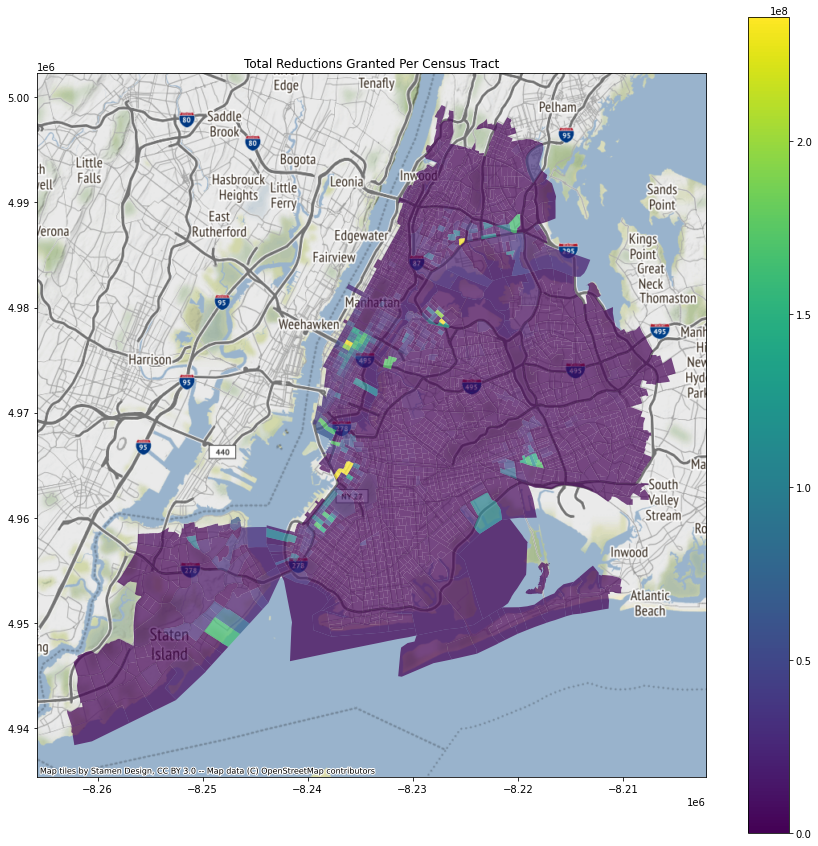

In [28]:
#plotting the total reduction granted per census tract to better visualize the distribution throughout NYC, with NaN values colored in as grey
fig, ax = plt.subplots(figsize=(15,15))
tractjoin.plot(column='total_tract_reduction', ax=ax, missing_kwds= dict(color = "grey"), alpha=.7, legend=True)
ctx.add_basemap(ax)
ax.set_title("Total Reductions Granted Per Census Tract")

Text(0.5, 1.0, 'Number of Reductions Granted Per Census Tract')

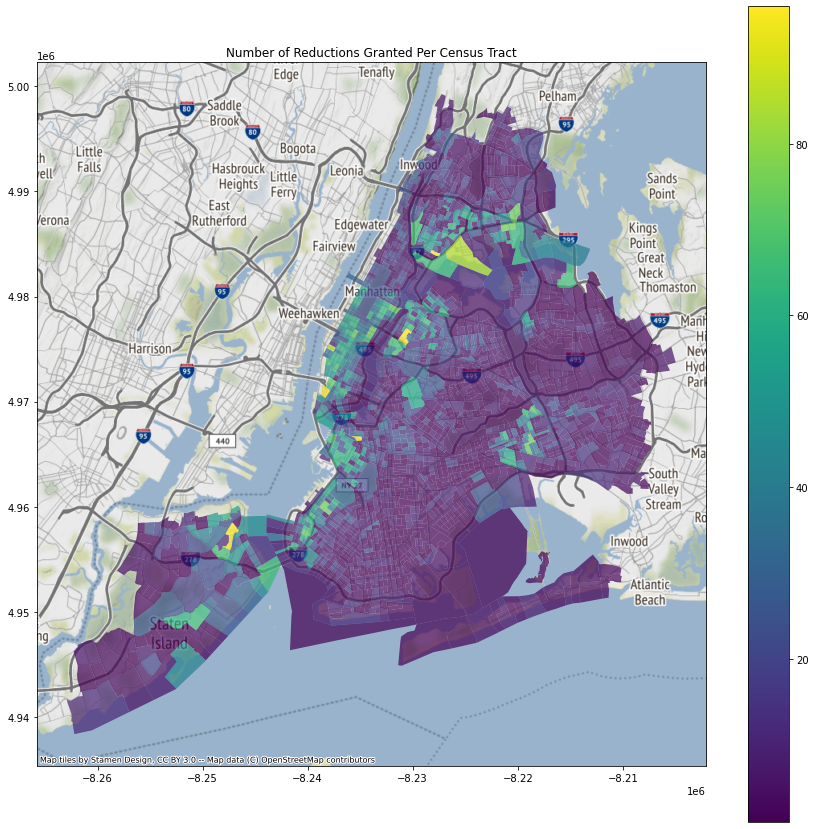

In [29]:
#plotting the number of reductions per census tract to better visualize where the most reductions have been, with NaN values colored in as grey
fig, ax = plt.subplots(figsize=(15,15))
tractjoin.plot(column='number_reductions', ax=ax, missing_kwds= dict(color = "grey"), alpha=.7, legend=True)
ctx.add_basemap(ax)
ax.set_title("Number of Reductions Granted Per Census Tract")

In [30]:
numberreductions.sort_values(by='number_reductions', ascending=False)

number_reductions
tract                    
003300                 96
009300                 85
009800                 75
010800                 74
009600                 74
...                   ...
062400                  1
062300                  1
061800                  1
061601                  1
990100                  1

[1299 rows x 1 columns]

# Machine Learning Attempt #1: Using tractjoin 

I'm going to try to use the both machine learning models to predict the number of reductions in each census tract, and the amount reduction (continouous variables). After assessing the results, if the model seems good then we can map them side by side. 

In [78]:
tractjoin.head()
tractjoin.columns

#Test 1 will use tractjoin to predict granted reduction amounts
Test1_columns_to_exclude = ['GEOID', 'geometry', 'state', 'county', 'tract','total_tract_reduction']
test1_yvar = 'total_tract_reduction'

#Test w will use tractjoin to predict number of reductions
Test2_columns_to_exclude = ['GEOID', 'geometry', 'state', 'county', 'tract','number_reductions']
test2_yvar = 'number_reductions'

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# I'm just going to throw in all of the columns
xvars = [col for col in tractjoin.columns if col not in Test1_columns_to_exclude]
yvar = test1_yvar

# create a dataframe with no NaNs
df_to_fit = tractjoin[xvars+[yvar]].dropna()

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

# initialize the random forest classifer object
rf = RandomForestRegressor(n_estimators = 50, random_state = 1)

# now fit the model
rf.fit(X_train, y_train)

# make predictions
y_pred = rf.predict(X_test)

In [80]:
y_test

872       137975.0
1502    10885094.0
955         4050.0
1044      403400.0
681      3520051.0
           ...    
312            0.0
457        19249.0
1866     4029690.0
575      2971029.0
827      1834750.0
Name: total_tract_reduction, Length: 503, dtype: float64

4.575904572564613


Text(0, 0.5, 'Predicted total tract reductions')

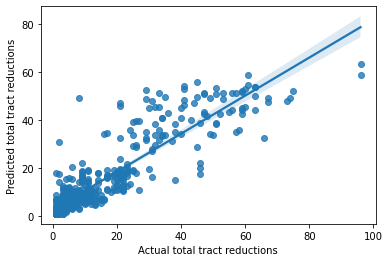

In [86]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

# Class notes use mean aboslute error, but idk how to interpret
print(metrics.mean_absolute_error(y_test, y_pred))

fig, ax = plt.subplots()
sns.regplot(x=y_test, y=y_pred, ax=ax)
ax.set_xlabel('Actual total tract reductions')
ax.set_ylabel('Predicted total tract reductions')

Text(0, 0.5, 'Predicted number of tract reductions')

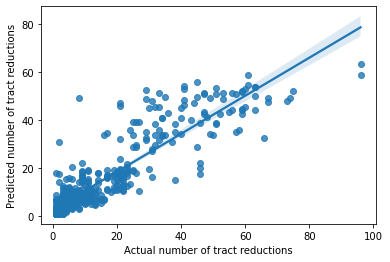

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

xvars = [col for col in tractjoin.columns if col not in Test2_columns_to_exclude]
yvar = test2_yvar

df_to_fit = tractjoin[xvars+[yvar]].dropna()

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

rf = RandomForestRegressor(n_estimators = 50, random_state = 1)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test, y=y_pred, ax=ax)
ax.set_xlabel('Actual number of tract reductions')
ax.set_ylabel('Predicted number of tract reductions')

# ML Attempt 2: Random Forests with Boolean

To begin, I wanted to create a column that tells us whether a property from the assesment dataset got a reduction or not. So I created a join, while removing duplicates, that would left join the actions to the valuations.

In [31]:
actions_df.index.is_unique
value_gdf.index.is_unique

False

In [32]:
#creating two new datasets just without duplicates

print('Before dropping duplicates: {}'.format(len(actions_df)))
actions_nodupl = actions_df.groupby('BBB').first()
print('After dropping duplicates: {}'.format(len(actions_nodupl)))
actions_nodupl.index.is_unique

#same thing with the other
print('Before dropping duplicates: {}'.format(len(value_gdf)))
value_nodupl = value_gdf.groupby('BBB').first()
print('After dropping duplicates: {}'.format(len(value_nodupl)))
value_nodupl.index.is_unique

Before dropping duplicates: 12321
After dropping duplicates: 10062
Before dropping duplicates: 1110058
After dropping duplicates: 1105748


True

In [33]:
# the join

NewDf_for_ML = value_nodupl.join(actions_nodupl, how='left')
print('Number of valuations: {}'.format(len(NewDf_for_ML)))
print('Number of reductions: {}'.format(NewDf_for_ML['granted_reduction_amount'].count()))

#Almost all of the reductions got added so i think this is fine

Number of valuations: 1105748
Number of reductions: 10004


In [34]:
NewDf_for_ML.granted_reduction_amount.fillna(0,inplace=True)
NewDf_for_ML['granted_reduction_amount'] = NewDf_for_ML['granted_reduction_amount'].astype(float)
NewDf_for_ML['got_reduction'] = NewDf_for_ML['granted_reduction_amount'] > 0
NewDf_for_ML.head()

geometry                          nta     avland  \
BBB                                                                           
1-1-10   POINT (-74.01287 40.69010)  park-cemetery-etc-Manhattan  104445450   
1-1-101  POINT (-74.04534 40.68989)  park-cemetery-etc-Manhattan    4225950   
1-1-201  POINT (-74.03975 40.69883)  park-cemetery-etc-Manhattan   14972400   
1-1-301                        None                         None          0   
1-1-401                        None                         None          0   

          latitude    zip stories      avtot easement valtype     exland  ...  \
BBB                                                                       ...   
1-1-10   40.690096  10004    None  161206200     None   AC-TR  104445450  ...   
1-1-101  40.689887  10004    None   12873150     None   AC-TR    4225950  ...   
1-1-201  40.698831  10004    None  111703950     None   AC-TR   14972400  ...   
1-1-301       None   None    None          0     None   AC-TR          0  ...   
1-1-401       None   None    None          0     None   AC-TR          0  ...   

        ltdepth borough_code block_number lot_number tax_year owner_name  \
BBB                                                                        
1-1-10        0          NaN          NaN        NaN      NaN        NaN   
1-1-101    1046          NaN          NaN        NaN      NaN        NaN   
1-1-201       0          NaN          NaN        NaN      NaN        NaN   
1-1-301       0          NaN          NaN        NaN      NaN        NaN   
1-1-401       0          NaN          NaN        NaN      NaN        NaN   

        property_address granted_reduction_amount tax_class_code got_reduction  
BBB                                                                             
1-1-10               NaN                      0.0            NaN         False  
1-1-101              NaN                      0.0            NaN         False  
1-1-201              NaN                      0.0            NaN         False  
1-1-301              NaN                      0.0            NaN         False  
1-1-401              NaN                      0.0            NaN         False  

[5 rows x 49 columns]

In [35]:
NewDf_for_ML.columns

Index(['geometry', 'nta', 'avland', 'latitude', 'zip', 'stories', 'avtot',
       'easement', 'valtype', 'exland', 'blddepth', 'year', 'taxclass',
       'longitude', 'bldfront', 'bldgcl', 'block', 'avtot2', 'excd1', 'bble',
       'staddr', 'exmptcl', 'avland2', 'census_tract', 'lot', 'boro',
       'ltfront', 'fullval', 'ext', 'bin', 'excd2', 'owner', 'extot', 'extot2',
       'exland2', 'community_board', 'borough', 'period', 'council_district',
       'ltdepth', 'borough_code', 'block_number', 'lot_number', 'tax_year',
       'owner_name', 'property_address', 'granted_reduction_amount',
       'tax_class_code', 'got_reduction'],
      dtype='object')

In [36]:
from sklearn.model_selection import train_test_split

#we can put more interesting variables as we sort them out, but for now i used these 3

xvars = ['avtot','avland', 'stories']

yvar = 'got_reduction'

df_to_fit = NewDf_for_ML[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

790188 790188
263397 263397


In [37]:
from sklearn.ensemble import RandomForestClassifier # note there is also a RandomForestRegressor

# initialize the random forest classifer object
rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

# now fit the model
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred

array([False, False, False, ..., False, False, False])

In [38]:
print(len(X_test), len(y_pred))

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print(confusion_matrix(y_test, y_pred))
confusion_matrix

263397 263397
[[260692    349]
 [  2254    102]]


<function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>

Text(0, 0.5, 'Mean decrease in impurity')

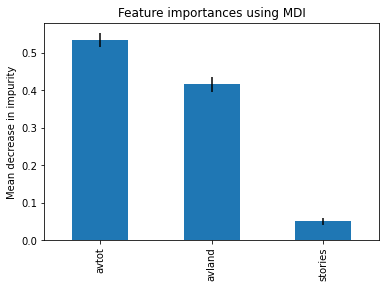

In [39]:
import numpy as np
importances = rf.feature_importances_

# convert to a series, and give the index labels from our X_train dataframe
forest_importances = pd.Series(importances, index=X_train.columns)

# get the standard deviations to be able to plot the error bars
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# plot importances
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")